# Dependencias

In [4]:
# PyTorch con Soporte CUDA
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# Instalando dependencias
!pip install --user pyarrow findspark pyspark tensorflow pandas scikit-learn ydata-profiling matplotlib numpy seaborn opencv-python pillow pydicom scikit-image lime tf-keras-vis numpy xgboost grad-cam easyocr==1.7.2 joblib

# Inicializacion

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

# Force add the project root to sys.path (adjust as needed)
project_root = Path("../").resolve()  # one level up from /notebooks/
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [4]:
# Calculos
import numpy as np
import pandas as pd

# PyTorch
import torch

# Visualizacion
#from ydata_profiling import ProfileReport #LIBRERIA COMENTADA*

# Utilidades
import os
import re

## Constantes

In [131]:
DATA_ABS_PATH                   = os.path.abspath("../data/CBIS-DDSM")
IMAGES_ABS_PATH                 = os.path.abspath("../data/CBIS-DDSM/CBIS-DDSM")
CLEANED_IMAGES_ABS_PATH         = os.path.abspath("../data/CBIS-DDSM/CLEANED-CBIS-DDSM") # Same as above but in .pgn
TEXT_CLEANED_IMAGES_ABS_PATH    = os.path.abspath("../data/CBIS-DDSM/TEXT-CLEANED-CBIS-DDSM") # Same as above but with text and white borders removed
MASS_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/mass_case_description_train_set.csv'
MASS_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/mass_case_description_test_set.csv'
CALC_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/calc_case_description_train_set.csv'
CALC_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/calc_case_description_test_set.csv'
METADATA_CSV                    = DATA_ABS_PATH + '/metadata.csv'

CBISDDSM_DF                     = DATA_ABS_PATH + '/meta/CBIS-DDSM.parquet'
CBISDDSM_FIXED_SET              = DATA_ABS_PATH + '/meta/CBIS-DDSM-fixed.parquet'
OUTPUT_TRAIN                    = DATA_ABS_PATH + '/meta/train_split.parquet'
OUTPUT_VAL                      = DATA_ABS_PATH + '/meta/val_split.parquet'
OUTPUT_TEST                     = DATA_ABS_PATH + '/meta/test_split.parquet'

FEATURES_OUTPUT_PATH            = os.path.abspath("../models/output/features/")
MODELS_OUTPUT_PATH              = os.path.abspath("../models/output/")
MODELS_LOGS_OUTPUT_PATH         = os.path.abspath("../models/logs/")

SKIP_TRAINING                   = True  #False
ENABLE_CLASSIFIERS              = True  #False
INFERENCE_OUTPUT                = os.path.abspath("../output")

LABEL_MAP = {
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 1, # Benigno sin necesidad de mas estudios
    "MALIGNANT": 2
}

## Sesion de Spark

In [6]:
import findspark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, BooleanType


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName("breast_cancer_detection").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/21 22:53:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/21 22:53:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Creacion de DataFrames

In [7]:
metadata_df = spark.read.csv(METADATA_CSV, header=True)
metadata_df.describe()

DataFrame[summary: string, Series UID: string, Collection: string, 3rd Party Analysis: string, Data Description URI: string, Subject ID: string, Study UID: string, Study Description: string, Study Date: string, Series Description: string, Manufacturer: string, Modality: string, SOP Class Name: string, SOP Class UID: string, Number of Images: string, File Size: string, File Location: string, Download Timestamp: string]

In [8]:
mass_train_df = spark.read.csv(MASS_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [9]:
mass_test_df = spark.read.csv(MASS_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_test_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [10]:
calc_train_df = spark.read.csv(CALC_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_train_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [11]:
calc_test_df = spark.read.csv(CALC_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_test_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

**Nota**: Hay algunas columnas que tienen caracteres especiales, como saltos de linea. Como la columna con la direccion del ROI:

In [12]:
calc_test_df.show(2, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+--------------------+-----------------+----------+---------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patient_id|breast density|left or right breast|image view|abnormality id|abnormality type|calc type           |calc distribution|assessment|pathology|subtlety|image file path                                                                                                                                                        |cro

Ahora reemplazare los nombres erroneos de las imagenes (000000.dcm) por su nombre real, segun el siguiente patron:

- **image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llama 1-1.dcm
- **cropped image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-1.dcm y se encuentran en las carpetas con el sufijo _1 (ejemplo: CC_1, MLO_1, etc.)
- **ROI mak file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-2.dcm y se encuentra en las carpetas con el sufijo _1

In [13]:
mass_train_df = mass_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("type", F.lit("mass"))

In [14]:
mass_test_df = mass_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("mass"))

In [15]:
calc_train_df = calc_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [16]:
calc_test_df = calc_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [17]:
mass_train_df.filter(F.col('image_path').isNotNull()).count()

1318

In [18]:
mass_train_df.select(F.col('patient_id')).show(5, truncate=False)

+----------+
|patient_id|
+----------+
|P_00001   |
|P_00001   |
|P_00004   |
|P_00004   |
|P_00004   |
+----------+
only showing top 5 rows



In [19]:
print('mass_train_df image_path null count:', mass_train_df.filter(F.col('image_path').isNotNull()).count())
print('mass_train_df cropped_path null count:', mass_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_train_df roi_path null count:', mass_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('mass_test_df image_path null count:', mass_test_df.filter(F.col('image_path').isNotNull()).count())
print('mass_test_df cropped_path null count:', mass_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_test_df roi_path null count:', mass_test_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_train_df image_path null count:', calc_train_df.filter(F.col('image_path').isNotNull()).count())
print('calc_train_df cropped_path null count:', calc_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_train_df roi_path null count:', calc_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_test_df cropped_path null count:', calc_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_test_df image_path null count:', calc_test_df.filter(F.col('image_path').isNotNull()).count())
print('calc_test_df roi_path null count:', calc_test_df.filter(F.col('roi_path').isNotNull()).count())

mass_train_df image_path null count: 1318
mass_train_df cropped_path null count: 1318
mass_train_df roi_path null count: 1318

mass_test_df image_path null count: 378
mass_test_df cropped_path null count: 378
mass_test_df roi_path null count: 378

calc_train_df image_path null count: 1546
calc_train_df cropped_path null count: 1546
calc_train_df roi_path null count: 1546

calc_test_df cropped_path null count: 326
calc_test_df image_path null count: 326
calc_test_df roi_path null count: 326


In [20]:
mass_train_df.filter(F.col('cropped_path').isNotNull()).count()

1318

In [21]:
mass_train_df.filter(F.col('roi_path').isNotNull()).count()

1318

In [22]:
mass_train_df.select(F.col('roi_path')).show(4, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|roi_path                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-1.dcm |
|Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-1.dcm|
|Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011

In [23]:
mass_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_train.parquet')
mass_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_test.parquet')
calc_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_train.parquet')
calc_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_test.parquet')

# Creacion de Train y Test datasets

Ahora combinare los datasets de test y de train para tener dos unicos datasets para cada fin, asi el modelo aprende tanto de masas como de calcificaciones y si son benignas o malignas.

In [24]:
train_df = mass_train_df.unionByName(calc_train_df, allowMissingColumns=True)
test_df = mass_test_df.unionByName(calc_test_df,  allowMissingColumns=True)

In [25]:
train_df.count()

2864

In [26]:
train_df.filter(F.col('image_path').isNotNull()).count()

2864

In [27]:
train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string, image_path: string, cropped_path: string, roi_path: string, type: string, calc type: string, calc distribution: string]

In [28]:
train_df.show(5, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+----------------------------------+-------------+----------+---------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------

Ahora solo nos interesa guardas las columnas que puedan aportar informacion valiosa para el entrenamiento, por lo que seleccionaremos las siguientes:
- **image_path**: Ruta hasta la imagen Dicom
- **cropped_path**: Ruta hasta la imagen Dicom recortada
- **roi_path**: Ruta hasta la imagen de Dicom de la region de interes
- **type**: Tipo de imagen (masa o calcificacion)
- **pathology**: Tipo de patologia (Benigna, Beningna sin mas examenes, Maligna)
- **abnormality type**: Tipo de anomalia detectada (masa o calcificacion) (tiene valores nulos)
- **assessment**: Escala de 0-5 que va correlacionada con **pathology**
- **breast_density**: Densidad de las mamas
- **calc distribution**: Distribucion de la calcificacion
- **calc type**: Tipo de la calcificacion
- **mass margins**: Margenes de las masas
- **mass shape**: Forma de las masas
- **image view**: Angulo de vision de la imagen
- **left or right breast**: Lateralidad del seno de la imagen
- **subtlety**: 

In [29]:
columns_to_keep = [
    "image_path",
    "cropped_path",
    "roi_path",
    "abnormality type",
    "assessment",
    "breast_density",
    "calc distribution",
    "calc type",
    "image view",
    "left or right breast",
    "mass margins",
    "mass shape",
    "subtlety",
    "type",
    "pathology" # Label
]

In [30]:
# These are the dataset as publicly available in the TCIA website, however, I'm going to merge them to keep one single dataset
# so I can create my own trainig, validation and test datasets later in the process.
# train_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TRAIN)
# test_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TEST)

full_df = train_df.select(*columns_to_keep).unionByName(test_df.select(*columns_to_keep))
full_df.write.mode("overwrite").parquet(CBISDDSM_DF)

---
# Verificacion de directorios

Dado que estoy cambiando manualmente los nombres de los archivos para que reflejen el nombre correcto descargado por el NBIA Data Retriever, tengo que asegurarme que las nuevas rutas corresponden
a los archivos descargados, por lo que cada una de las rutas tiene que corresponder a un archivo existente en el directorio de las imágenes.

Para ello, se emplea un script de Pandas que vaya fila a fila por cada ruta y verifique su existencia haciendo uso de .exists()

In [31]:
COLUMNS_TO_CHECK = ["image_path", "cropped_path", "roi_path"]
cbisddsm_df = pd.read_parquet(CBISDDSM_DF)

def check_wrong_paths(df, columns_to_check):
    for col in columns_to_check:
        if col not in cbisddsm_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
        
        def check_exists(relative_path):
            if not isinstance(relative_path, str):
                return False
            # Normalize and build full path
            normalized = Path(relative_path.replace("/", "\\"))  # Replace backslashes if any
            full_path = (TEXT_CLEANED_IMAGES_ABS_PATH / normalized).resolve()
            return full_path.exists()
    
        cbisddsm_df[f"{col}_exists"] = cbisddsm_df[col].apply(check_exists)
    
    # Print full-width output
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    
    print(cbisddsm_df[[*COLUMNS_TO_CHECK, *(f"{col}_exists" for col in COLUMNS_TO_CHECK)]].describe())

In [32]:
check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

In [33]:
missing_roi = cbisddsm_df[cbisddsm_df["roi_path_exists"] == False]
print(missing_roi[COLUMNS_TO_CHECK + [f"{col}_exists" for col in COLUMNS_TO_CHECK]])

                                                                                                                                                                     image_path  \
0       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm   
1      Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-1.dcm   
2        Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-1.dcm   
3      Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-1.dcm   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.

## Observaciones

Podemos observar que algunas rutas no existen, esto se debe a que no todos los archivos anteriores siguen el mismo formato, sin embargo, el formato de nombres 1-1.dcm y 1-2.dcm se mantiene luego de revisar los archivos exhaustivamente. Por lo que se corregirán los 12 casos anteriores con otro scrip en Pandas.

**Nota**: Se usa Pandas dado que Spark no tiene una función para acceder al File System, por lo que crear una UDF que verifique la existencia del archivo iría en contra del principio distribuido de PySpark, por lo que luego del procesamiento inicial, ya no es necesario.

In [34]:
bad_indexes = missing_roi.index.tolist()

for idx in bad_indexes:
    path = cbisddsm_df.at[idx, "roi_path"]
    if isinstance(path, str):
        cbisddsm_df.at[idx, "roi_path"] = re.sub(r"/[^/]+$", "/1-1.dcm", path)

check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

## Observaciones

Una vez corregidos los nombres de los archivos, ahora guardamos el dataset corregido para pasar al entrenamiento.

In [35]:
cbisddsm_df.to_parquet(CBISDDSM_FIXED_SET, index=False)

# Observaciones
Luego de corregir los nommbres de todos los archivos dicom en el dataset, ya podemos hacer uso de estos archivos junto con sus etiquetas de patologia, por lo que podemos pasar al a fase de entrenamiento del modelo.

In [36]:
spark.stop()

# Entrenamiento de Modelos

Primero, vamos a confirmar que Jupyter puede ver y usar la GPU. Se espera True y NVIDIA GeForce RTX 3070

In [37]:
#torch.cuda.is_available(), torch.cuda.get_device_name(0)

In [38]:
import uuid
correlation_id = str(uuid.uuid4())

In [71]:
# General
import torch
from pathlib import Path

# Datasets
from datasets.cbisddsm import CBISDDSMDataset

# Models (choose one per run)
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel

# Training
from training.engine import Trainer
from training.focal_loss import FocalLoss
from training.early_stopping import EarlyStopping
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# Visualization
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)

# Constants
from utils.constants import TEXT_CLEANED_IMAGES_ABS_PATH, LABEL_MAP, MODELS_OUTPUT_PATH

# Torch utils
from torch.utils.data import DataLoader

In [72]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq


# Load full dataset to split
cbisddsm_df = pq.read_table(CBISDDSM_FIXED_SET).to_pandas()
train_df, test_df = train_test_split(cbisddsm_df, test_size=0.2, stratify=cbisddsm_df["pathology"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["pathology"], random_state=42)

# Save temporary splits
train_df.to_parquet("train.parquet", index=False)
val_df.to_parquet("val.parquet", index=False)
test_df.to_parquet("test.parquet", index=False)

# Visualizacion previa al entrenamiento

Acá la idea es validar los datos que se encuentran en los conjuntos de Training, Test y Validación.

In [120]:
train_df.drop(['image_path','cropped_path','roi_path'], axis=1)#.profile_report()

,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,mass margins,mass shape,subtlety,type,pathology,image_path_exists,cropped_path_exists,roi_path_exists,full_image_path,exists,mean_intensity,std_intensity,width,height
0,mass,3,1,None,None,MLO,RIGHT,CIRCUMSCRIBED,LOBULATED,4,mass,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Test_P_01395_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.341904992912998335902563580790499510885/1.3.6.1.4.1.9590.100.1.2.57854390411125252714525874340062956276/1-1.dcm,True,0.276493,0.255702,2968,4712
1,mass,5,4,None,None,CC,RIGHT,SPICULATED,ARCHITECTURAL_DISTORTION,2,mass,MALIGNANT,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Test_P_01110_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.168531566311720526519976731010007084293/1.3.6.1.4.1.9590.100.1.2.265901326713324251300096756542729360549/1-1.dcm,True,0.177803,0.250622,4051,6871
2,mass,3,2,None,None,MLO,LEFT,CIRCUMSCRIBED,OVAL,4,mass,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_00401_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.212227071411874305812725756301569606300/1.3.6.1.4.1.9590.100.1.2.296558944912772058418981961040600019022/1-1.dcm,True,0.225781,0.255833,3560,5792
3,calcification,4,2,CLUSTERED,PLEOMORPHIC,CC,RIGHT,None,None,2,calc,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33738713811858436016999284533372535797/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/1-1.dcm,True,0.181317,0.239942,2506,4591
4,mass,3,4,None,None,CC,RIGHT,OBSCURED,OVAL,3,mass,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_01557_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.12176605211639215630138082851961900822/1.3.6.1.4.1.9590.100.1.2.107360897713717564406875465542927267856/1-1.dcm,True,0.243918,0.302651,2356,4531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,calcification,4,3,CLUSTERED,PLEOMORPHIC-AMORPHOUS,CC,LEFT,None,None,3,calc,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Test_P_00353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.145734018111291645519131313920862306101/1.3.6.1.4.1.9590.100.1.2.374083122712703142909330807542822451571/1-1.dcm,True,0.200412,0.268399,3056,4624
2827,calcification,4,2,CLUSTERED,AMORPHOUS,MLO,RIGHT,None,None,4,calc,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Test_P_01152_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.224940358711959912716061746282663742362/1.3.6.1.4.1.9590.100.1.2.194868667012564968127301658993026023368/1-1.dcm,True,0.194595,0.244912,4088,5816
2828,mass,3,1,None,None,MLO,RIGHT,N/A,ARCHITECTURAL_DISTORTION,1,mass,MALIGNANT,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Mass-Training_P_00439_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.2607049911612584438352718542090027770/1.3.6.1.4.1.9590.100.1.2.223200299211434089119224646431205382397/1-1.dcm,True,0.305131,0.299692,2648,4712
2829,calcification,2,2,LINEAR,N/A,MLO,LEFT,None,None,5,calc,BENIGN,False,False,False,/Users/clubability/Documents/GitHub/breast_cancer_detection/data/CBIS-DDSM/CBIS-DDSM/Calc-Training_P_00642_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.123534161512512745416544679680548390246/1.3.6.1.4.1.9590.100.1.2.49475239112846459001560766733059381722/1-1.dcm,True,0.129140,0.206826,3976,5576


In [74]:
test_df.drop(['image_path','cropped_path','roi_path'], axis=1)#.profile_report()

,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,mass margins,mass shape,subtlety,type,pathology,image_path_exists,cropped_path_exists,roi_path_exists
785,mass,3,2,None,None,MLO,RIGHT,N/A,FOCAL_ASYMMETRIC_DENSITY,5,mass,BENIGN_WITHOUT_CALLBACK,False,False,False
1477,calcification,4,3,CLUSTERED,PLEOMORPHIC,CC,LEFT,None,None,3,calc,BENIGN,False,False,False
2616,calcification,2,3,N/A,ROUND_AND_REGULAR-LUCENT_CENTERED,CC,RIGHT,None,None,3,calc,BENIGN_WITHOUT_CALLBACK,False,False,False
113,mass,5,1,None,None,MLO,RIGHT,MICROLOBULATED,LOBULATED,5,mass,MALIGNANT,False,False,False
2351,calcification,5,1,CLUSTERED-LINEAR,FINE_LINEAR_BRANCHING,MLO,RIGHT,None,None,4,calc,MALIGNANT,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,mass,4,3,None,None,MLO,RIGHT,MICROLOBULATED,LOBULATED,5,mass,MALIGNANT,False,False,False
217,mass,4,3,None,None,MLO,LEFT,CIRCUMSCRIBED-OBSCURED,OVAL,2,mass,BENIGN,False,False,False
3099,mass,5,3,None,None,MLO,RIGHT,SPICULATED,IRREGULAR,1,mass,MALIGNANT,False,False,False
3,mass,4,3,None,None,MLO,LEFT,ILL_DEFINED,ARCHITECTURAL_DISTORTION,3,mass,BENIGN,False,False,False


In [75]:
val_df.drop(['image_path','cropped_path','roi_path'], axis=1)#.profile_report()

,abnormality type,assessment,breast_density,calc distribution,calc type,image view,left or right breast,mass margins,mass shape,subtlety,type,pathology,image_path_exists,cropped_path_exists,roi_path_exists
2541,calcification,4,4,CLUSTERED,PUNCTATE-AMORPHOUS,CC,RIGHT,None,None,4,calc,BENIGN,False,False,False
1991,calcification,4,4,CLUSTERED,PLEOMORPHIC,CC,LEFT,None,None,1,calc,MALIGNANT,False,False,False
1615,calcification,2,1,CLUSTERED,COARSE-PLEOMORPHIC,MLO,RIGHT,None,None,5,calc,BENIGN,False,False,False
1654,calcification,2,3,N/A,VASCULAR-COARSE,CC,LEFT,None,None,3,calc,BENIGN_WITHOUT_CALLBACK,False,False,False
2835,calcification,5,1,LINEAR,PLEOMORPHIC,CC,LEFT,None,None,5,calc,MALIGNANT,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,mass,5,1,None,None,CC,RIGHT,SPICULATED,IRREGULAR-ARCHITECTURAL_DISTORTION,5,mass,MALIGNANT,False,False,False
1949,calcification,4,3,CLUSTERED,PLEOMORPHIC,CC,LEFT,None,None,4,calc,MALIGNANT,False,False,False
2517,calcification,5,3,CLUSTERED,PLEOMORPHIC,CC,RIGHT,None,None,4,calc,MALIGNANT,False,False,False
264,mass,5,2,None,None,CC,LEFT,ILL_DEFINED,OVAL,3,mass,MALIGNANT,False,False,False


In [121]:
import datetime
from sklearn.metrics import confusion_matrix
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)
from utils.feature_extraction import build_route, extract_features
from training.trainer_config import TrainerConfig, TransformConfig
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel
from models.base_model import BaseModel
from models.classifiers.svm_classifier import SVMClassifier
#from models.classifiers.xgboost_classifier import XGBoostClassifier
from models.classifiers.base_classifier import BaseClassifier
from torchvision import transforms

results = []

configs = {
    #"ResNet50": TrainerConfig(
        #model_name="ResNet50",
        #dropout_rate=0.5,
        #freeze_base=False,
        #transforms=TransformConfig(
            #use_augmentations=True,
            #resize=224,
            #horizontal_flip_prob=0.5,
            #rotation_degrees=10,
            #translate=0.05,
            #scale_min=0.95,
            #scale_max=1.05,
            #brightness=0.2,
            #contrast=0.2,
            #blur_sigma_min=0.3,
            #blur_sigma_max=1.2,
            #normalize_mean=0.5,
            #normalize_std=0.5
        #)
    #),
    # "EfficientNetB0": TrainerConfig(
    #     model_name="EfficientNetB0",
    #     dropout_rate=0.5,
    #     freeze_base=False,
    #     transforms=TransformConfig(
    #         use_augmentations=True,
    #         resize=224,
    #         horizontal_flip_prob=0.5,
    #         rotation_degrees=10,
    #         translate=0.05,
    #         scale_min=0.95,
    #         scale_max=1.05,
    #         brightness=0.2,
    #         contrast=0.2,
    #         blur_sigma_min=0.3,
    #         blur_sigma_max=1.2,
    #         normalize_mean=0.5,
    #         normalize_std=0.5
    #     )
    # ),
    # "MobileNetV3": TrainerConfig(
    #     model_name="MobileNetV3",
    #     dropout_rate=0.5,
    #     freeze_base=False,
    #     transforms=TransformConfig(
    #         use_augmentations=True,
    #         resize=224,
    #         horizontal_flip_prob=0.5,
    #         rotation_degrees=10,
    #         translate=0.05,
    #         scale_min=0.95,
    #         scale_max=1.05,
    #         brightness=0.2,
    #         contrast=0.2,
    #         blur_sigma_min=0.3,
    #         blur_sigma_max=1.2,
    #         normalize_mean=0.5,
    #         normalize_std=0.5
    #     )
    # ),
    "SVM": TrainerConfig(
        model_name="SVM",
        dropout_rate=0.0,
        freeze_base=True,
    ),
    #"XGBoost": TrainerConfig(
    #    model_name="XGBoost",
    #    dropout_rate=0.0,
    #    freeze_base=True,
    #),
}

strategy_classes = {
    #"ResNet50": ResNetModel,
    #"EfficientNetB0": EfficientNetModel,
    #"MobileNetV3": MobileNetModel,
    "SVM": SVMClassifier,
    #"XGBoost": XGBoostClassifier
}

strategies = {
    name: strategy_classes[name](config=configs[name], search_hyperparameters=True)
    if name in ["SVM"] else strategy_classes[name](config=configs[name])
    for name in configs.keys()
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLORMAPS = {
    "image": "Purples",
    "cropped": "Greens",
    "roi": "Oranges"
}

In [122]:
def load_or_extract_features(df, split: str, base_dir: str):
    """
    Load feature `.parquet` if it exists, otherwise compute and save it.

    Args:
        df (pd.DataFrame): The base dataframe with image paths.
        split (str): One of 'train', 'val', 'test'.
        base_dir (str): Directory where feature parquet files are stored.

    Returns:
        pd.DataFrame: DataFrame with extracted features.
    """
    feature_path = os.path.join(base_dir, f"{split}_features.parquet")

    if os.path.exists(feature_path):
        print(f"[INFO] Loading precomputed features for '{split}' from: {feature_path}")
        return pd.read_parquet(feature_path)

    print(f"[INFO] Extracting features for '{split}' (not cached)...")
    df = build_route(df, images_base_path=IMAGES_ABS_PATH)
    df = extract_features(df)
    df.to_parquet(feature_path, index=False)
    print(f"[INFO] Saved features to {feature_path}")
    return df

In [123]:
train_df = load_or_extract_features(train_df, "train", FEATURES_OUTPUT_PATH)
val_df   = load_or_extract_features(val_df, "val", FEATURES_OUTPUT_PATH)
test_df  = load_or_extract_features(test_df, "test", FEATURES_OUTPUT_PATH)

[INFO] Loading precomputed features for 'train' from: /Users/clubability/Documents/GitHub/breast_cancer_detection/models/output/features/train_features.parquet
[INFO] Loading precomputed features for 'val' from: /Users/clubability/Documents/GitHub/breast_cancer_detection/models/output/features/val_features.parquet
[INFO] Loading precomputed features for 'test' from: /Users/clubability/Documents/GitHub/breast_cancer_detection/models/output/features/test_features.parquet


In [80]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    for model_name, strategy in strategies.items():
        print(f"\n==== Training {model_name} ====")
    
        if isinstance(strategy, BaseModel):
            config = strategy.config
            train_transform = strategy.get_transforms(train=True)
            eval_transform = strategy.get_transforms(train=False)
        else:
            config = None
            train_transform = eval_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
    
        train_dataset = CBISDDSMDataset("train_features.parquet", transform=train_transform, multi_view=False, images_base_path=IMAGES_ABS_PATH)
        val_dataset   = CBISDDSMDataset("val_features.parquet", transform=eval_transform, multi_view=False, images_base_path=IMAGES_ABS_PATH)
        test_dataset  = CBISDDSMDataset("test_features.parquet", transform=eval_transform, multi_view=False, images_base_path=IMAGES_ABS_PATH)
    
        train_loader = DataLoader(train_dataset, batch_size=70, shuffle=True, num_workers=8, pin_memory=True)
        val_loader   = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=8, pin_memory=True)
        test_loader  = DataLoader(test_dataset, batch_size=70, shuffle=False, num_workers=8, pin_memory=True)

        run_dir = os.path.join(MODELS_OUTPUT_PATH, correlation_id)
        os.makedirs(run_dir, exist_ok=True)
    
        if isinstance(strategy, BaseModel):
            model = strategy.get_model().to(device)
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
            scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=config.scheduler_patience, min_lr=1e-6)
            criterion = FocalLoss(gamma=config.gamma, alpha=config.alpha)
            early_stopping = EarlyStopping(
                monitor="val_recall",
                mode="max",
                patience=config.early_stop_patience,
                delta=0.001
            )
    
            trainer = Trainer(
                model=model,
                device=device,
                optimizer=optimizer,
                criterion=criterion,
                scheduler=scheduler,
                early_stopping=early_stopping
            )
    
            trainer.fit(train_loader, val_loader, epochs=50)
    
            model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
            trainer.save_best_model(model_path)
            trainer.load_model(model_path)
    
            acc, loss, recall, precision, f1, auc, per_view_metrics, per_view_predictions, per_class_metrics = trainer.evaluate(test_loader)
    
            results.append({
                "model": model_name,
                "accuracy": acc,
                "recall": recall,
                "precision": precision,
                "f1_score": f1,
                "auc_roc": auc
            })
    
            for view, metrics in per_view_metrics.items():
                results.append({
                    "model": model_name,
                    "view": view,
                    "accuracy": metrics["accuracy"],
                    "recall": metrics["recall"],
                    "precision": metrics["precision"],
                    "f1_score": metrics["f1"],
                    "auc_roc": metrics["auc"]
                })

            for class_name, metrics in per_class_metrics.items():
                results.append({
                    "model": model_name,
                    "class": class_name,
                    "accuracy": metrics["accuracy"],
                    "recall": metrics["recall"],
                    "precision": metrics["precision"],
                    "f1_score": metrics["f1"],
                    "auc_roc": metrics["auc_roc"]
                })
    
            history_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}_history.csv")
            save_training_history_to_csv(trainer.get_history(), history_path)
            plot_training_history(trainer.get_history(), model_name=model_name)
    
            for view, pred_data in per_view_predictions.items():
                plot_confusion_matrix(
                    y_true=pred_data["y_true"],
                    y_pred=pred_data["y_pred"],
                    class_names=["BENIGN", "NO_CALLBACK", "MALIGNANT"],
                    title=f"{model_name} - {view.capitalize()} Confusion Matrix",
                    cmap=COLORMAPS.get(view.lower(), "Greys")
                )
    
            y_true, y_pred = [], []
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    preds = model(images).argmax(dim=1)
                    y_pred.extend(preds.cpu().numpy())
                    y_true.extend(labels.numpy())

            # Omitted for single view runs
            # plot_confusion_matrix(
            #     y_true=y_true,
            #     y_pred=y_pred,
            #     class_names=["BENIGN", "NO_CALLBACK", "MALIGNANT"],
            #     title=f"{model_name} - Overall Confusion Matrix",
            #     cmap="Blues"
            # )

            torch.cuda.empty_cache()
            del model
        elif isinstance(strategy, BaseClassifier): 
            strategy.fit(train_df)
        
            model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pkl")
            strategy.save_model(model_path)
        
            strategy.load_model(model_path)
        
            # Evaluate on test and validation sets
            test_metrics = strategy.evaluate(test_df)
            val_metrics = strategy.evaluate(val_df)
            
            results.append({
                "model": model_name,
                "split": "test",
                "accuracy": test_metrics["accuracy"],
                "recall": test_metrics["recall"],
                "precision": test_metrics["precision"],
                "f1_score": test_metrics["f1_score"],
                "auc_roc": test_metrics["auc_roc"],
                "view": "image"
            })
            
            print(f"\n==== Evaluation for {model_name} ====")
            print("Validation:")
            for metric, value in val_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")
            print("Test:")
            for metric, value in test_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")


==== Training SVM ====
/Users/clubability/Documents/GitHub/breast_cancer_detection/notebooks train_features.parquet
/Users/clubability/Documents/GitHub/breast_cancer_detection/notebooks val_features.parquet
/Users/clubability/Documents/GitHub/breast_cancer_detection/notebooks test_features.parquet
['mean_intensity', 'std_intensity', 'width', 'height', 'assessment', 'breast_density', 'subtlety']
pathology
[[ 1.09982582  0.15236014 -0.41657641 ... -0.17633592 -1.49367408
   0.24335329]
 [-0.35676666  0.03006303  1.52068321 ...  1.3715927   1.67697674
  -1.49418307]
 [ 0.35134946  0.15551388  0.6423873  ... -0.17633592 -0.43679047
   0.24335329]
 ...
 [ 1.52250327  1.21131383 -0.98898922 ... -0.17633592 -1.49367408
  -2.36295126]
 [-1.07499713 -1.02419807  1.38652396 ... -0.95030022 -0.43679047
   1.11212148]
 [-0.6151073  -0.04269504 -0.2019216  ...  0.59762839  0.62009314
  -0.62541489]] [0 2 0 ... 2 0 2]
Performing GridSearchCV for SVM hyperparameter tuning...
Fitting 3 folds for each

SVM
            model split  accuracy   recall  precision  f1_score   auc_roc  \
model_view                                                                  
SVM - image   SVM  test  0.768657  0.78612   0.804084  0.792577  0.917981   
SVM - image   SVM  test  0.768657  0.78612   0.804084  0.792577  0.918105   

              view class  
model_view                
SVM - image  image  <NA>  
SVM - image  image  <NA>  
Saved per-view plot to /Users/clubability/Documents/GitHub/breast_cancer_detection/models/logs/39c3f9ec-bd5a-40a8-af27-b8d06468f33a/svm_per_view.png


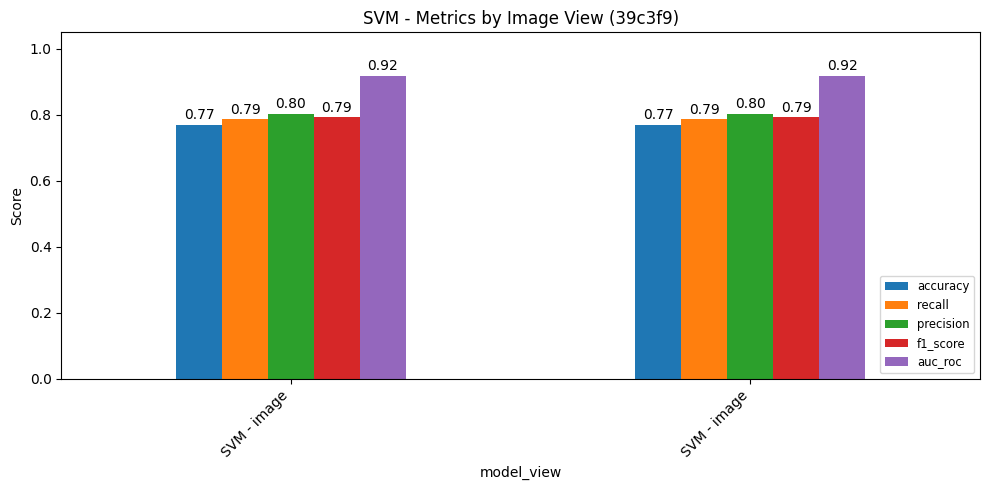

In [109]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    import pandas as pd
    import matplotlib.pyplot as plt
    import os

    results_df = pd.DataFrame(results)

    save_path = os.path.join(MODELS_LOGS_OUTPUT_PATH, correlation_id)
    os.makedirs(save_path, exist_ok=True)

    raw_path = os.path.join(save_path, f"summary_test_results_{correlation_id}.csv")
    results_df_rounded = results_df.round(4)
    results_df_rounded.to_csv(raw_path, index=False)
    #print(f"Saved results to {raw_path}")

    # Fill default values for missing columns
    results_df["view"] = results_df.get("view", "global").fillna("global")
    results_df["class"] = results_df.get("class", pd.NA)

    # --- Plot: Per-View ---
    view_df = results_df[results_df["class"].isna()].copy()
    view_df["model_view"] = view_df["model"] + " - " + view_df["view"]
    view_df.set_index("model_view", inplace=True)
    
    for model in view_df["model"].unique():
        print(model)
        model_data = view_df[view_df["model"] == model]
        print(model_data)

        drop_cols = ["model", "view", "class"]
        title = f"{model} - Metrics by Image View ({correlation_id[:6]})"

        ax = model_data.drop(columns=drop_cols).plot(
            kind="bar",
            figsize=(10, 5),
            title=title
        )
        plt.ylabel("Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.05)
        plt.legend(loc="lower right", fontsize="small")
        plt.tight_layout()

        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

        plot_path = os.path.join(save_path, f"{model.lower()}_per_view.png")
        plt.savefig(plot_path)
        print(f"Saved per-view plot to {plot_path}")
        plt.show()



    # --- Plot: Per-Class ---
    class_df = results_df[results_df["class"].notna()].copy()
    class_df["model_class"] = class_df["model"] + " - " + class_df["class"]
    class_df.set_index("model_class", inplace=True)

    for model in class_df["model"].unique():
        model_data = class_df[class_df["model"] == model]

        drop_cols = ["model", "view", "class"]
        title = f"{model} - Metrics by Class ({correlation_id[:6]})"

        ax = model_data.drop(columns=drop_cols).plot(
            kind="bar",
            figsize=(10, 5),
            title=title
        )
        plt.ylabel("Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.05)
        plt.legend(loc="lower right", fontsize="small")
        plt.tight_layout()

        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

        plot_path = os.path.join(save_path, f"{model.lower()}_per_class.png")
        plt.savefig(plot_path)
        print(f"Saved per-class plot to {plot_path}")
        #plt.show()

---
# Comparación entre experimentos

Veamos el progreso entre nuestros experimentos.

File not found: /Users/clubability/Documents/GitHub/breast_cancer_detection/models/logs/a141fb95-3ae4-4039-b425-585c3aeeb646/summary_test_results_a141fb95-3ae4-4039-b425-585c3aeeb646.csv
/Users/clubability/Documents/GitHub/breast_cancer_detection/models/logs/39c3f9ec-bd5a-40a8-af27-b8d06468f33a/summary_test_results_39c3f9ec-bd5a-40a8-af27-b8d06468f33a.csv
Index(['model', 'split', 'accuracy', 'recall', 'precision', 'f1_score',
       'auc_roc', 'view'],
      dtype='object')


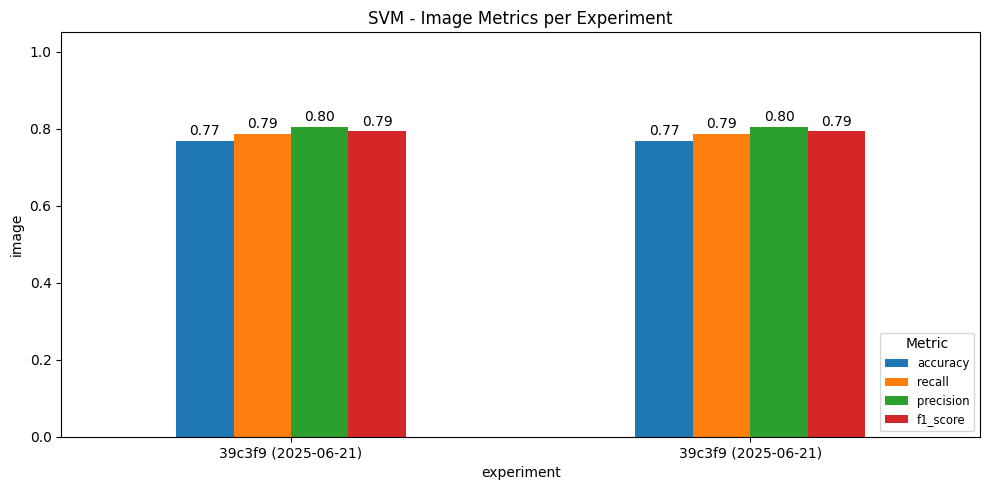

In [82]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    def plot_multiple_experiment_results(exp_ids: list[str], logs_path: str):
        all_results = []
    
        for exp_id in exp_ids:
            count = 0
            file_path = os.path.join(logs_path, f"summary_test_results_{exp_id}.csv")
    
            if not os.path.exists(file_path) and count==0:
                corr_logs_path = logs_path + '/' + exp_id + '/'
                file_path = os.path.join(corr_logs_path, f"summary_test_results_{exp_id}.csv")
                count += 1
                if not os.path.exists(file_path) and count==1:
                    print(f"File not found: {file_path}")
                    continue
    
            # Read file and creation date
            df = pd.read_csv(file_path)
            creation_time = os.path.getctime(file_path)
            creation_date = datetime.fromtimestamp(creation_time).strftime("%Y-%m-%d")

            print(file_path)

            print(df.columns)
            
            # Add experiment label
            experiment_label = f"{exp_id[:6]} ({creation_date})"
            df["experiment"] = experiment_label
            df["view"] = df["view"].fillna("global")
            all_results.append(df)
    
        if not all_results:
            print("No valid result files found.")
            return
    
        combined_df = pd.concat(all_results, ignore_index=True)
    
        metric_cols = ["accuracy", "recall", "precision", "f1_score"]
        view_order = ["global", "image", "cropped", "roi"]
    
        for model in combined_df["model"].unique():
            model_df = combined_df[combined_df["model"] == model].copy()
    
            for view in view_order:
                view_df = model_df[model_df["view"] == view].copy()
                if view_df.empty:
                    continue
    
                # Build DataFrame: index = experiment, columns = metric
                plot_df = view_df.set_index("experiment")[metric_cols]
    
                ax = plot_df.plot(kind="bar", figsize=(10, 5))
                plt.title(f"{model} - {view.capitalize()} Metrics per Experiment")
                plt.ylabel(view)
                plt.xticks(rotation=0)
                plt.ylim(0, 1.05)
                plt.legend(title="Metric", fontsize="small", loc="lower right")
                plt.tight_layout()
    
                for container in ax.containers:
                    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)
    
                plt.show()
    
    experiment_ids = ['a141fb95-3ae4-4039-b425-585c3aeeb646', correlation_id]
    plot_multiple_experiment_results(experiment_ids, MODELS_LOGS_OUTPUT_PATH)

# Inferencias

A continuación, se cargan los modelos entrenados previamente para poder obtener predicciones sobre conjuntos de datos mediante el módilo de inferencias (Inference) implementado en el proyecto.

## Inferencia uno a uno

Se testea el módulo de inferencia usando el método que recibe una imagen como entrada.

In [153]:
model_name="ResNet50"

In [155]:
import os
import torch
from inference.cnn_predictor import CNNPredictor
from utils.dicom import load_image
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel


label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"resnet50_{correlation_id}.pth")

strategy = strategies[model_name]

predictor = CNNPredictor(strategy, model_path, label_list=label_list)

image_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/1-1.dcm"
cropped_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-1.dcm"
roi_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-2.dcm"

mal_image_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm"
mal_cropped_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-1.dcm"
mal_roi_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-2.dcm"


#image_path = IMAGES_ABS_PATH + "\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm"
#cropped_path = IMAGES_ABS_PATH + "\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-1.dcm"
#roi_path = IMAGES_ABS_PATH + "\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-2.dcm"

#mal_image_path = IMAGES_ABS_PATH + "\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm"
#mal_cropped_path = IMAGES_ABS_PATH + "\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-1.dcm"
#mal_roi_path = IMAGES_ABS_PATH + "\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-2.dcm"

image = load_image(mal_image_path)

result = predictor.predict(image)
print(f"Predicted class: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['all_probs']}")

KeyError: 'ResNet50'

In [165]:
from inference.classifier_predictor import ClassifierPredictor

image_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/1-1.dcm"
cropped_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-1.dcm"
roi_path = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/1-2.dcm"

#r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM
mal_image_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm"
mal_cropped_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-1.dcm"
mal_roi_path = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-2.dcm"

# Load strategy and model
strategy = strategies["SVM"]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
else:
    correlation_id = "39c3f9ec-bd5a-40a8-af27-b8d06468f33a"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")

predictor = ClassifierPredictor(strategy, model_path)

# Load image (PNG, JPG, or preprocessed DICOM)
# image = load_image(image_path)
parquet_path = FEATURES_OUTPUT_PATH + "/val_df_clean.parquet"
df = pd.read_parquet(parquet_path)
feature_cols = strategy.feature_columns
X = df[feature_cols].values.astype(float)
X_scaled = strategy.scaler.transform(X)

# Predict
result = predictor.predict(X_scaled)

print(f"Predicted class: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['all_probs']}")

Predicted class: 0
Confidence: 0.7140
Probabilities: [0.714 0.022 0.264]


In [169]:
if ENABLE_CLASSIFIERS:
    from inference.classifier_predictor import ClassifierPredictor
    
    # Load strategy and model
    strategy = strategies["SVM"]
    
    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
    else:
        correlation_id = "39c3f9ec-bd5a-40a8-af27-b8d06468f33a"
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")
    
    predictor = ClassifierPredictor(strategy, model_path)
    
    parquet_path = FEATURES_OUTPUT_PATH + "/val_df_clean.parquet"
    df = pd.read_parquet(parquet_path)
    feature_cols = strategy.feature_columns
    X = df[feature_cols].values.astype(float)
    X_scaled = strategy.scaler.transform(X)
    # Predict
    result = predictor.predict(X_scaled)
    
    print(f"Predicted class: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {result['all_probs']}")
else:
    print("Classifiers disabled")

Predicted class: 0
Confidence: 0.7140
Probabilities: [0.714 0.022 0.264]


In [170]:
if ENABLE_CLASSIFIERS:
    from inference.classifier_predictor import ClassifierPredictor
    
    # Load strategy and model
    strategy = strategies["XGBoost"]
    
    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"xgboost_{correlation_id}.pkl")
    else:
        correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"xgboost_{correlation_id}.pkl")
    
    predictor = ClassifierPredictor(strategy, model_path)
    
    # Load image (PNG, JPG, or preprocessed DICOM)
    image = load_image(image_path)
    
    # Predict
    result = predictor.predict(image)
    
    print(f"Predicted class: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {result['all_probs']}")
else:
    print("Classifiers disabled")

KeyError: 'XGBoost'

---

## Inferencia uno a uno (directorio)

Se testea el módulo de inferencia usando el método que recibe la dirección del archivo como entrada.

In [55]:
import os
from inference.cnn_predictor import CNNPredictor

label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
strategy = strategies[model_name]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"resnet50_{correlation_id}.pth")

predictor = CNNPredictor(strategy, model_path, label_list=label_list)

benign_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm",
    'cropped': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-1.dcm",
    'roi': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-2.dcm"
}

malignant_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm",
    'cropped': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-1.dcm",
    'roi': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-2.dcm"
}

for k, v in benign_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

for k, v in malignant_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

[Benign image] Predicted: 1 (BENIGN_WITHOUT_CALLBACK) | Confidence: 0.47
[Benign cropped] Predicted: 0 (BENIGN) | Confidence: 0.39
[Benign roi] Predicted: 2 (MALIGNANT) | Confidence: 0.57
[Malignant image] Predicted: 2 (MALIGNANT) | Confidence: 0.82
[Malignant cropped] Predicted: 2 (MALIGNANT) | Confidence: 0.77
[Malignant roi] Predicted: 2 (MALIGNANT) | Confidence: 0.45


In [176]:
if ENABLE_CLASSIFIERS:
    import os
    from inference.classifier_predictor import ClassifierPredictor
    
    
    label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    strategy = strategies["SVM"]
    
    if not SKIP_TRAINING or not ENABLE_CLASSIFIERS:
        model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
    else:
        correlation_id = "39c3f9ec-bd5a-40a8-af27-b8d06468f33a"
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")
    
    predictor = ClassifierPredictor(strategy, model_path, label_list)
    bening_dict_image = IMAGES_ABS_PATH + "/Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/1-1.dcm"
    benign_dict = {
        'image': bening_dict_image
    }
    malignant_dict_image = IMAGES_ABS_PATH + "/Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm"
    malignant_dict = {
        'image': malignant_dict_image
    }
    df = pd.read_parquet(parquet_path)
    scaler       = predictor.strategy.scaler
    #idxs         = [all_cols.index(c) for c in feature_cols]
    means        = scaler.mean_
    scales       = scaler.scale_
    for idx, row in df.iterrows():
        if idx >= 10:
            break
        x_raw    = row[feature_cols].values.astype(float)
        x_scaled = (x_raw - means) / scales
    
        probs      = strategy.model.predict_proba(x_scaled.reshape(1, -1))[0]
        pred_idx   = int(probs.argmax())
        confidence = float(probs[pred_idx])
        label      = label_list[pred_idx]
    
        print(
            f"[Fila {idx}] Predicted class: {pred_idx} ({label})  "
            f"| Confidence: {confidence:.2f}  "
            f"| Probabilities: {[round(p, 3) for p in probs]}"
        )    
    # # Run predictions
    # for k, v in benign_dict.items():
    #     result = predictor.predict_from_path(v)
    #     print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")
    
    # for k, v in malignant_dict.items():
    #     result = predictor.predict_from_path(v)
    #     print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")
else:
    print("Classifiers disabled")

[Fila 0] Predicted class: 0 (benigno_sin_callback)  | Confidence: 0.71  | Probabilities: [0.714, 0.022, 0.264]
[Fila 1] Predicted class: 2 (maligno)  | Confidence: 0.71  | Probabilities: [0.286, 0.007, 0.706]
[Fila 2] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.89  | Probabilities: [0.105, 0.893, 0.002]
[Fila 3] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.89  | Probabilities: [0.054, 0.888, 0.058]
[Fila 4] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.89  | Probabilities: [0.054, 0.888, 0.058]
[Fila 5] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.89  | Probabilities: [0.054, 0.888, 0.058]
[Fila 6] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.89  | Probabilities: [0.054, 0.888, 0.058]
[Fila 7] Predicted class: 2 (maligno)  | Confidence: 0.93  | Probabilities: [0.057, 0.008, 0.934]
[Fila 8] Predicted class: 1 (benigno_con_callback)  | Confidence: 0.95  | Probabilities: [0.043, 0.953, 0.004]
[Fila 9] Predicted class: 2

In [57]:
if ENABLE_CLASSIFIERS:
    import os
    from inference.classifier_predictor import ClassifierPredictor
    
    
    label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    strategy = strategies["XGBoost"]
    
    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"xgboost_{correlation_id}.pkl")
    else:
        correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"xgboost_{correlation_id}.pkl")
    
    predictor = ClassifierPredictor(strategy, model_path, label_list)
    
    benign_dict = {
        'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm",
    }
    
    malignant_dict = {
        'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm",
    }
    
    # Run predictions
    for k, v in benign_dict.items():
        result = predictor.predict_from_path(v)
        print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")
    
    for k, v in malignant_dict.items():
        result = predictor.predict_from_path(v)
        print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")
else:
    print("Classifiers disabled")

Classifiers disabled


---

## Inferencia por lotes (directorio)
Se testea el módulo de inferencia usando el método que recibe la dirección de una carpeta como entrada, ejecuntando la inferencia en el primer nivel del directorio.

In [58]:
import os
from inference.cnn_predictor import CNNPredictor

label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
cnn_names = ["ResNet50", "EfficientNetB0", "MobileNetV3"]

for model_name in cnn_names:
    print(f"\n==== Bach inference for {model_name} ====")
    strategy = strategies[model_name]
    
    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
    else:
        correlation_id = "590cfd6e-cba8-48dd-a31e-d1bbca240247" # Known working experiment uuid
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"{model_name}_{correlation_id}.pth")
    
    predictor = CNNPredictor(strategy, model_path, label_list=label_list)
    
    external_studies_path = r"D:\TFM\breast_cancer_detection\data\inbreast_subset"
    
    results = predictor.predict_directory(
        dir_path=external_studies_path,
        correlation_id=correlation_id,
        output_path=INFERENCE_OUTPUT,
        output_file_name=f"{model_name}_inference.csv"
    )
    
    for r in results:
        print(f"{r['filename']}: {r['prediction']} ({r['class_label']}) — {r['confidence']:.2f}")



==== Bach inference for ResNet50 ====
[INFO] Results saved to D:\TFM\breast_cancer_detection\output\5128832b-2804-41fd-bb29-19d51fdd8005\ResNet50_inference_20250610_190424.csv
22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm: 0 (BENIGN) — 0.56
22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.55
53581406_b231a8ba4dd4214f_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.55
53581460_b231a8ba4dd4214f_MG_R_CC_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.64

==== Bach inference for EfficientNetB0 ====
[INFO] Results saved to D:\TFM\breast_cancer_detection\output\5128832b-2804-41fd-bb29-19d51fdd8005\EfficientNetB0_inference_20250610_190425.csv
22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.54
22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.42
53581406_b231a8ba4dd4214f_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.68
53581460_b231a8ba4dd4214f_MG_R_CC_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.60

==== Bach inferenc

In [111]:
if ENABLE_CLASSIFIERS:
    import os
    from inference.classifier_predictor import ClassifierPredictor
    
    label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    classifier_names = ["SVM", "XGBoost"]
    
    for model_name in classifier_names:
        print(f"\n==== Bach inference for {model_name} ====")
        strategy = strategies[model_name]
    
        if not SKIP_TRAINING:
            model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
        else:
            correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0" # Known working experiment uuid
            model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")
        
        predictor = ClassifierPredictor(strategy, model_path, label_list=label_list)
        
        external_studies_path = r"D:\TFM\breast_cancer_detection\data\busi_subset"
        
        results = predictor.predict_directory(
            dir_path=external_studies_path,
            correlation_id=correlation_id,
            output_path=INFERENCE_OUTPUT,
            output_file_name=f"{model_name}_inference.csv"
        )
        
        for r in results:
            print(f"{r['filename']}: {r['prediction']} ({r['class_label']}) — {r['confidence']:.2f}")
else:
    print("Classifiers disabled")

Classifiers disabled


---

# Explicabilidad

En el siguiente apartado, se agrega explicabilidad a las predicciones realizadas por un modelo ya entrenado anteriormente con el fin de poder visualizar en qué areas de las imágenes se centra un modelo para realizar una predicción.

In [60]:
model_name = "EfficientNetB0"

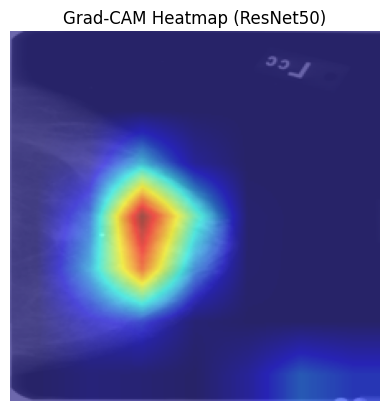

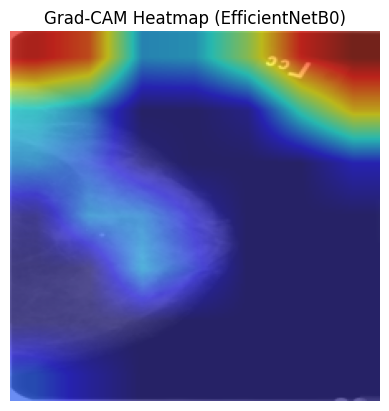

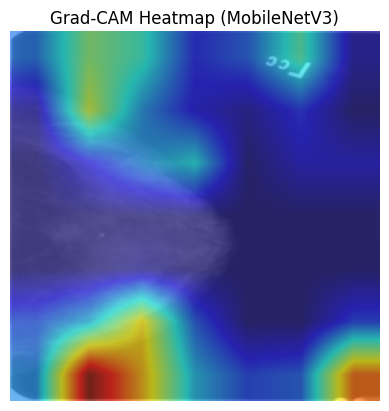

In [61]:
from inference.gradcam_explainer import GradCAMExplainer
import matplotlib.pyplot as plt

cnn_names = ["ResNet50", "EfficientNetB0", "MobileNetV3"]

for model_name in cnn_names:
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"{model_name.lower()}_{correlation_id}.pth")
    strategy = strategies[model_name]
    predictor = CNNPredictor(strategy, model_path, label_list=label_list)
    
    explainer = GradCAMExplainer(predictor=predictor)
    
    image = load_image(mal_image_path)
    
    cam_image = explainer.explain(image)
    
    plt.imshow(cam_image)
    plt.axis('off')
    plt.title(f"Grad-CAM Heatmap ({model_name})")
    plt.show()